In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network

## Template 03
## FIFA dataset 

<img src='../../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, r'G:\My Drive\DNN')
from collections.abc import Callable
from typing import Literal

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [3]:
print (fn_plot_tf_hist.__doc__)


    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    


In [4]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


In [5]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../input'
outDir = '../output'
modelDir = './models'
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 101 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [6]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## Read FIFA 2019 data set

In [7]:
data_df = pd.read_csv(r'fifa_2019.csv')
data_df.shape

(18207, 89)

In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18207 non-null  int64  
 1   ID                        18207 non-null  int64  
 2   Name                      18207 non-null  object 
 3   Age                       18207 non-null  int64  
 4   Photo                     18207 non-null  object 
 5   Nationality               18207 non-null  object 
 6   Flag                      18207 non-null  object 
 7   Overall                   18207 non-null  int64  
 8   Potential                 18207 non-null  int64  
 9   Club                      17966 non-null  object 
 10  Club Logo                 18207 non-null  object 
 11  Value                     18207 non-null  object 
 12  Wage                      18207 non-null  object 
 13  Special                   18207 non-null  int64  
 14  Prefer

In [9]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,18207.0,9103.000000,5256.052511,0.0,4551.5,9103.0,13654.5,18206.0
ID,18207.0,214298.338606,29965.244204,16.0,200315.5,221759.0,236529.5,246620.0
Age,18207.0,25.122206,4.669943,16.0,21.0,25.0,28.0,45.0
Overall,18207.0,66.238699,6.908930,46.0,62.0,66.0,71.0,94.0
Potential,18207.0,71.307299,6.136496,48.0,67.0,71.0,75.0,95.0
Special,18207.0,1597.809908,272.586016,731.0,1457.0,1635.0,1787.0,2346.0
International Reputation,18159.0,1.113222,0.394031,1.0,1.0,1.0,1.0,5.0
Weak Foot,18159.0,2.947299,0.660456,1.0,3.0,3.0,3.0,5.0
Skill Moves,18159.0,2.361308,0.756164,1.0,2.0,2.0,3.0,5.0
Jersey Number,18147.0,19.546096,15.947765,1.0,8.0,17.0,26.0,99.0


In [10]:
data_df.isna().sum().sum()

76984

In [11]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [12]:
data_df[data_df['Name']=="S. Chhetri"]

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
8605,8605,190939,S. Chhetri,33,https://cdn.sofifa.org/players/4/19/190939.png,India,https://cdn.sofifa.org/flags/159.png,67,67,NaN,...,67.0,30.0,24.0,44.0,10.0,7.0,11.0,9.0,10.0,NaN


In [13]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [14]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [15]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [16]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [17]:
labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [18]:
y = data_df["Position"].to_numpy()

X = data_df.drop("Position", axis = 1)

In [19]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14517, 33) (14517,) (3630, 33) (3630,)


In [20]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [21]:
type(X_train), type(X_test), type(y_train),type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [22]:
import tensorflow as tf

In [23]:
test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [24]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [25]:
# Shuffle and batch the dataset
train_ds = train_ds.shuffle(buffer_size=X_train.shape[0]).batch(BATCH_SIZE)
test_ds = test_ds.shuffle(buffer_size=X_test.shape[0]).batch(BATCH_SIZE)

In [26]:
## Optimize for performance

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
for features, labels in train_ds.take(1):
    print (features.shape, labels.shape)

(32, 33) (32,)


In [28]:
inputs = tf.keras.Input(shape=(33,))
    
x = tf.keras.layers.Dense(18, activation=tf.nn.relu)(inputs)

outputs = tf.keras.layers.Dense(4)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [29]:
predictions = model(features).numpy()
predictions.shape

(32, 4)

In [30]:
predictions[0].sum()

2.9785247

In [31]:
tf.nn.softmax(predictions).numpy()[0]

array([0.04624473, 0.40102905, 0.33486077, 0.21786542], dtype=float32)

In [32]:
tf.nn.softmax(predictions).numpy().sum(axis = 1)[0]

0.99999994

In [33]:
'''
Number of parameters:
    layer 1 : 33*18 +18 = 612 
    layer 2 : 18*4 + 4
We are not locking any layer hence all parameter are trainable    
'''

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 18)             │           612 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 688 (2.69 KB)

 Trainable params: 688 (2.69 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy ( from_logits = True)

In [35]:
labels

<tf.Tensor: shape=(32,), dtype=int8, numpy=
array([1, 2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1,
       2, 2, 0, 1, 2, 3, 3, 3, 2, 1], dtype=int8)>

In [36]:
loss_fn(labels, predictions).numpy()

1.8532705

In [37]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [38]:
history = model.fit(train_ds, 
                    validation_data=test_ds,
                    epochs=EPOCHS)

Epoch 1/101
454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6470 - loss: 0.8424 - val_accuracy: 0.8444 - val_loss: 0.3715
Epoch 2/101
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8532 - loss: 0.3605 - val_accuracy: 0.8642 - val_loss: 0.3280
Epoch 3/101
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8675 - loss: 0.3295 - val_accuracy: 0.8683 - val_loss: 0.3153
Epoch 4/101
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8724 - loss: 0.3181 - val_accuracy: 0.8705 - val_loss: 0.3094
Epoch 5/101
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8752 - loss: 0.3116 - val_accuracy: 0.8708 - val_loss: 0.3063
Epoch 6/101
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8756 - loss: 0.3071 - val_accuracy: 0.8713 - val_loss: 0.3040
Epoch 7/101
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8768 - loss: 0.3039 - val_accuracy: 0.8727 - val_loss: 0.3026
Epoch 8/101
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8778 - loss: 0.3013 - val_accu

In [39]:
model.evaluate ( test_ds, verbose=2)

114/114 - 0s - 1ms/step - accuracy: 0.8702 - loss: 0.3064


[0.3063869774341583, 0.8702479600906372]

In [40]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.766205,0.573021,0.844353,0.371460
1,0.861955,0.338515,0.864187,0.328041
2,0.871599,0.314911,0.868320,0.315261
3,0.875043,0.305403,0.870523,0.309406
4,0.877867,0.299956,0.870799,0.306251


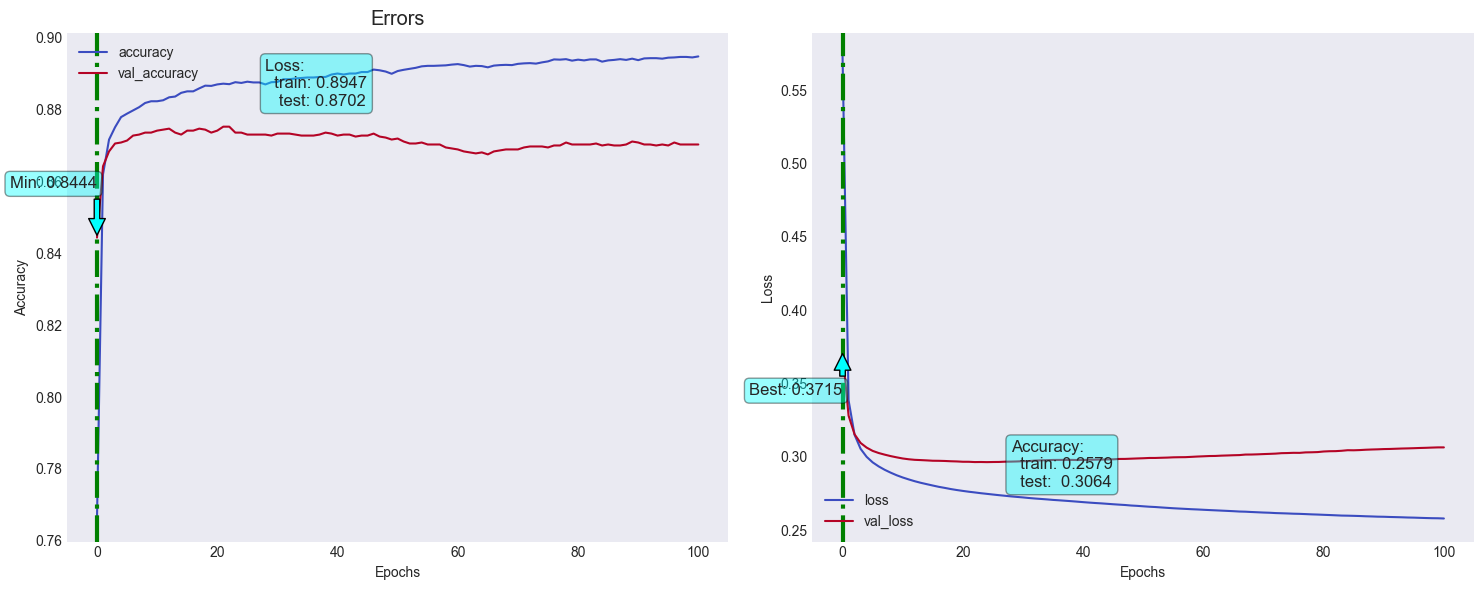

In [41]:
fn_plot_tf_hist(loss_df)

In [42]:
loss_df[loss_df['val_loss'] == loss_df['val_loss'].min()]

,accuracy,loss,val_accuracy,val_loss
24,0.887373,0.274694,0.873554,0.296338


In [43]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [44]:
y_pred = probability_model(X_train).numpy()
y_pred.shape

(14517, 4)

In [45]:
print(classification_report( y_train, y_pred.argmax( axis = 1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.93      0.94      0.93      4693
           2       0.84      0.90      0.87      5470
           3       0.90      0.76      0.82      2734

    accuracy                           0.90     14517
   macro avg       0.92      0.90      0.91     14517
weighted avg       0.90      0.90      0.89     14517



In [46]:
y_pred = probability_model(X_test).numpy()

print('Accuracy score on Test Data :{:.5f}'.format(accuracy_score(y_test, 
                                                                  np.argmax(y_pred, axis = 1))))

Accuracy score on Test Data :0.87025


In [47]:
print(classification_report(y_test, 
                            np.argmax(y_pred, axis = 1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.91      0.92      0.92      1173
           2       0.81      0.87      0.84      1368
           3       0.85      0.71      0.77       684

    accuracy                           0.87      3630
   macro avg       0.89      0.87      0.88      3630
weighted avg       0.87      0.87      0.87      3630

